## Purpose


The purpose of this code is to complete the selection of the Lockheed Martin's Drone Challenge "Alpha Pilot" (https://www.herox.com/alphapilot/77-test-2)

The Alpha Pilot Test 2 evaluates team's skills in both Computer Vision and Machine Learning, by predicting gate locations on images :

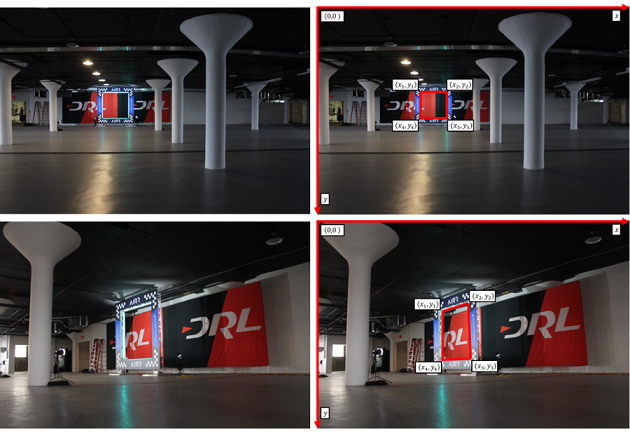

Our approach starts from the winner of the IROS 2018 Drone Competition, [DroNet Learning to fly by driving](http://rpg.ifi.uzh.ch/docs/RAL18_Loquercio.pdf)
Then, attempt to use it to the Alpha Pilot context.  
We named this new version : DroGate


## 1. Import librairies and modules

The following requirements shall be installed before import :

* Tensorflow (recommanded : 1.12.0)
* OpenCV (recommanded : 4.0.0)
* Seaborn (recommanded : 0.9.0)

You will also need last versions of : numpy, python-wget, zipfile, json


In [73]:
## Import librairies and modules

import numpy as np
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers,Input
from tensorflow.keras import models
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from random import choice
from random import sample
from numpy.linalg import norm

import time
import wget
import zipfile
import os
import json


## Define local tree
data_path='data/' 
tmp_path="tmp/"
images_path=data_path+"images/"
labels_path=data_path+"labels/"
training_images_path=images_path+"Data_Training/"
np_training_labels=labels_path+"image_coordinates_dictionnary_v2.npy"
json_training_labels=labels_path+"training_GT_labels_v2.json"
leaderboard_images_path=images_path+"Data_LeaderboardTesting/"

## Create local tree for Training
def mkdir_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

mkdir_exists(data_path)
mkdir_exists(tmp_path)
mkdir_exists(images_path)
mkdir_exists(labels_path)
mkdir_exists(training_images_path)
mkdir_exists(leaderboard_images_path)


## 2. Downloading Alpha Pilot ressources

This shall be executed only once, it will download  :

* The Training Dataset :  9,300 images totaling 2.8GB, and their labels. 
* The Test2 Leaderboard Dataset :  1,000 images totaling 360MB.

It may take time.

In [11]:
# URLs from Alpha Pilot ressources 
url_training_images="https://s3.amazonaws.com/herox-alphapilot/Data_Training.zip"
url_training_labels="https://d253pvgap36xx8.cloudfront.net/challenges/resources/30b15372357911e9a16a0242ac110002/training_GT_labels_v2.json"
url_leaderboard_images="https://s3.amazonaws.com/herox-alphapilot/Data_LeaderboardTesting.zip"

# Downloading Ressources
  
def download_unzip_delete(url,target_dir):
    print("Downloading from : " + url)
    zip_filename=wget.download(url, tmp_path)
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    print("Unzipping to " + target_dir)
    zip_ref.extractall(target_dir)
    zip_ref.close()
    os.remove(zip_filename)
    print("Finished!")

download_unzip_delete(url_leaderboard_images, images_path)
download_unzip_delete(url_training_images, images_path)
wget.download(url_training_labels,labels_path)

'data/labels//training_GT_labels_v2.json'

In [69]:
# Load json labels file  
with open(json_training_labels) as f:
    data = json.load(f)
# and convert it to numpy file     
image_coordinate_dictionary={k:data[k][0] for k in data.keys()}
np.save(np_training_labels,image_coordinate_dictionary)

## 3. Define Visualisation  tools

We define visualisation tools on images to be able to answer questions like :

* Why my label isn't well predicted ?
* Which form does my gate get ?

In [53]:
def image_name_from_number(image_number):
        return list(image_coordinate_dictionary.keys())[image_number]
           

def draw_label (image_number,label):
    image_name=image_name_from_number(image_number)
    label=image_coordinate_dictionary[image_name]
    img=cv2.imread(images_path+image_name)
    
    pts = np.array([[label[0],label[1]],[label[2],label[3]],[label[4],label[5]],[label[6],label[7]]])
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    pol=patches.Polygon(pts,closed=True,fill=0,edgecolor='r',linewidth=3)

    ax.add_patch(pol)
    plt.ion()
    plt.show()

## 4. Images preprocessing

Before loading testing images, we apply a preprocessing based on labels quality, by automatically detecting Gates Coordinates far from corresponding to the known form, a Trapeze (projection of a rectangle).
They are considered as "outliers" and deleted.

Outlier detection code can be found on : [DataAnalysis_DroGate.ipynb](DataAnalysis_DroGate.ipynb) and shall be executed before the code below.

In [ ]:
#Local tree
preprocessing_path="preprocessing/"
outlier_labels=preprocessing_path+"outliers.npy"

# Delete outliers from Training set
outliers=np.load(outlier_labels)
 
for o in outliers:
        id_img=image_name_from_number(o)
        del image_coordinate_dictionary[id_img]
        

## 5. Define and adapt DroNet 

This code is taken from [rpg_public_dronet](https://github.com/uzh-rpg/rpg_public_dronet/blob/master/cnn_models.py) and adapted to keep only one output channel, to predict the gate coordinates.



In [58]:
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Add as add
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers


def resnet8(img_width, img_height, img_channels, output_dim):
    """
    Define model architecture.
    
    # Arguments
       img_width: Target image widht.
       img_height: Target image height.
       img_channels: Target image channels.
       output_dim: Dimension of model output.
       
    # Returns
       model: A Model instance.
    """

    # Input
    img_input = Input(shape=(img_height, img_width, img_channels))

    x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same')(img_input)
    x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(x1)

    # First residual block
    x2 = BN()(x1)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x2 = BN()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same')(x1)
    x3 = add()([x1, x2])

    # Second residual block
    x4 = BN()(x3)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x4 = BN()(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same')(x3)
    x5 = add()([x3, x4])

    # Third residual block
    x6 = BN()(x5)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x6 = BN()(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same')(x5)
    x7 = add()([x5, x6])

    x = Flatten()(x7)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # output channel
    out = Dense(output_dim)(x)
   

    # Define  model
    model = Model(inputs=[img_input], outputs=out)
    return model

drogate_model=resnet8(image_width,image_height,image_channels,8)

## 6. Training DroNet

We avoid to load all images by doing memory optimization :
* We load them only in batch sampling.
* We resize images  to defined values ( see 1. section)

This section below is executed by tuning Hyperparameters as many time as necessary. 

In [ ]:
## Define constants
image_width = 300 # 864
image_height = 300 # 1296
image_channels = 1 # 3

#Training 

# Define generator to optimize memory

def my_generator(batch_size):
    while 1:
        try:
            image_names = sample(image_coordinate_dictionary.keys(), batch_size)
            X = [cv2.resize(cv2.imread(training_images_path + image_name, 0), (image_height, image_width)) for image_name in image_names]
            X = np.array(X).astype(Type).reshape(batch_size,
                                                 image_height, image_width, image_channels)
            X = X/255
            Y = [image_coordinate_dictionary[image_name] for image_name in image_names]
            Y = np.reshape(Y, (batch_size, 8))
            yield (X, Y)
        except:
            # Do nothing
            pass 
            # Print the problem


my_generator(20)        

# Hyperparameters    
opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
batch_size = 10
steps = len(image_coordinate_dictionary)/batch_size
ep=15 

drogate_model.compile(optimizer=opt, loss='mse', metrics=['mae']) 
drogate_model.fit_generator( my_generator(batch_size) , steps_per_epoch=steps , epochs=ep)
 

## 7. Completing Leaderboard Test

1. Load images from Leaderboard test images
2. Run prediction using model
4. Transform predictions to dictionnary and save as a json file for submission.


In [79]:
# Loading loaderboard images

leaderboard_images_names=os.listdir(leaderboard_images_path)
images=[]

images_path=leaderboard_images_path

for image_file_name in leaderboard_images_names:
    image_file_path=images_path +image_file_name
    im=cv2.resize(cv2.imread(image_file_path,0),(image_reshape[1],image_reshape[0]))
    images.append(im) 

X=np.stack(images[i] for i in range(len(images))).astype('float32').reshape((len(images),image_reshape[1],image_reshape[0],1))
X=X/255

labels={}
y=drogate_model.predict(X)
for i in range(len(leaderboard_images_names)):
    labels[leaderboard_images_names[i]]=y[i]
    
#Converting numpy array to list
new_labels={}
for key in labels.keys():
    new_labels[key]=[[int(np.round_(i)) for i in labels[key]]]  

#Saving in json 
output_path="output/"
output_leaderboard_file=output_path+"DrobotLeaderboard_Test2.json"
mkdir_exists(output_path)

with open(output_leaderboard_file, 'w') as fp:
    json.dump(new_labels, fp)